In [2]:
import pandas as pd
pd.set_option("display.max_rows", 150)
pd.set_option('display.max_colwidth', -1)

import numpy as np

import glob

import gpxpy
import gpxpy.gpx

import re

from IPython.display import display, HTML

import requests
import pickle

In [3]:
# functions for judging a description
not_flowing_keywords = ["dry", "no water", "no flow", "not "]
def isNotFlowing(description):
    return any([kw in description for kw in not_flowing_keywords])
assert(isNotFlowing("looks dry"))

flowing_keywords = ["good", "flowing", "flow", "lots", "working"]
def isFlowing(description):
    return any([kw in description for kw in flowing_keywords])
assert(isFlowing("flowing well"))

In [4]:
# a function that tries to fix a location id, leaves non-waypoint labels alone in case they are in the gps data
# fixes the leading zeros problem WR004 = WR0004
def clean_loc_id(id):
    try:
        waypoint_search = re.search('((?:WR|WA)(?:CS|))([0-9]+)', id, re.IGNORECASE)

        if waypoint_search:        
            waypoint_type = waypoint_search.group(1)
            waypoint_num = waypoint_search.group(2)

            return f"{waypoint_type}{int(waypoint_num):04}"
    except:
        return id
    return id
assert(clean_loc_id("WR004") == "WR0004")

In [5]:
# functions for finding the last positive result and last negative result
def last_pos(mile, date):
    last_pos_date = data[(data.mile == mile) & (data.status==1) & (data.date < date)].date.max()
    if type(last_pos_date) == float:
        return 1000
    return (date - last_pos_date).days
    
def last_neg(mile, date):
    last_neg_date = data[(data.mile == mile) & (data.status==0) & (data.date < date)].date.max()    
    if type(last_neg_date) == float:
        return 1000
    return (date - last_neg_date).days

In [6]:
# create a lat, lon, and name dictionaries keyed on loc_ids 
waypoints = []
for path in glob.glob("gps/*.gpx"):
    gpx_file = open(path, 'r')
    gpx = gpxpy.parse(gpx_file)
    waypoints += (gpx.waypoints)
    
lat = {clean_loc_id(wp.name):wp.latitude for wp in waypoints}
lon = {clean_loc_id(wp.name):wp.longitude for wp in waypoints}

In [7]:
# a generator for sequentially reading in the data
def data_generator():
    for f in glob.glob("pct_data/*.xlsx"):
        data = pd.read_excel(f).dropna()
        _,cols = data.shape
        if cols == 7:
            data.columns = ["map","mile","loc_id","name", "description", "date", "user"]
        if cols == 8:
            data.columns = ["map","mile_2","mile","loc_id","name", "description", "date", "user"]
        yield data

In [8]:
# import and combine tip line data
data_tip = pd.concat(data_generator())

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [9]:
data_gh=pd.read_csv("guthook_data/PCTWater-wpts-Comments.csv").rename(columns=
    {
        "Date":"date",
        "WptId":"loc_id",
        "WptName":"name",
        "Latitude":"lat",
        "Longitude":"lon",
        "Comment":"description",
        "PCT Mile": "mile"
    })

In [10]:
# clean up the guthook dates
data_gh.date = pd.to_datetime(data_gh.date)

In [11]:
# clean up the lod_ids in the tip line data
data_tip.loc_id = data_tip.loc_id.apply(clean_loc_id)

In [12]:
# create lat and lon columns
data_tip["lat"] = data_tip["loc_id"].map(lat)
data_tip["lon"] = data_tip["loc_id"].map(lon)

In [13]:
# merge the two mile fields in the tip lin data
data_tip.mile = data_tip.mile.fillna(data_tip.mile_2)

In [26]:
# drop data with missing coordinates
data_tip = data_tip.dropna(subset=["lat", "mile"])

In [27]:
data = pd.concat([data_tip, data_gh])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [28]:
# clean up the descriptions
data.description = data.description.str.split("\n").str[0].str.lower()

In [29]:
# create a unix time column
data["unix_time"] = (pd.to_datetime(data["date"], errors='coerce').astype(np.int64)//1000000000)

In [30]:
# create not_flowing and flowing columns
data["not_flowing"] = data["description"].map(isNotFlowing, na_action="ignore")
data["flowing"] = data["description"].map(isFlowing, na_action="ignore")
data["decision"] = data.flowing^data.not_flowing # logical xor
data["status"] = data.flowing.astype(float)

In [31]:
print(f"one {(data.flowing^data.not_flowing).sum()}")
print(f"both {(data.flowing&data.not_flowing).sum()}")
print(f"either {(data.flowing|data.not_flowing).sum()}")

one 40560
both 2159
either 42719


In [32]:
# remove all data with no decision
data = data[data.decision]

In [33]:
# remove duplicate entries (ones with the same date and loc_id)
data = data.drop_duplicates(subset=["date","mile"])

In [34]:
miles = list(data.groupby("mile").nunique().sort_values(by="date")[-50:].loc_id.index)

In [35]:
data = data[data.mile.isin(miles)]

In [36]:
data.shape

(3975, 16)

In [41]:
# create last positive and negative result columns
data["last_pos"] = data.apply(lambda row: last_pos(row.mile, row.date), axis=1)
data["last_neg"] = data.apply(lambda row: last_neg(row.mile, row.date), axis=1)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
data["prob_exp"] = data.apply(lambda row: data[row.mile == data.mile].status.mean(), axis=1)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
try:
    f = open('rain_memo_coords.pkl', 'rb')
    rain_memo = pickle.load(f)
    f.close()
except:
    rain_memo = {}

def getRainfall(lat, lon, unix_time):
    lat, lon = round(lat,2),round(lon,2)
    if (lat, lon, unix_time) in rain_memo:
        return rain_memo[(lat,lon, unix_time)]
    print(f"{lat},{lon},{unix_time} not found, calling DarkSky")
    r = requests.get(f"https://api.darksky.net/forecast/840fdc3fb61acc3d4e904978b5ba8dc5/{lat},{lon},{unix_time}?exclude=currently,minutely,hourly,alerts")
    
    try:
        rain = r.json()["daily"]["data"][0]["precipIntensity"]
        rain_memo[(lat, lon, unix_time)] = rain
    except:
        rain = 0
        print(f"Data parse error {lat},{lon},{unix_time}")
        
    f = open('rain_memo_coords.pkl', 'wb')
    pickle.dump(rain_memo, f)
    f.close() 
    
    return rain

In [44]:
def getRainSum(lat, lon, unix_time, n):
    return 24 * sum([getRainfall(lat, lon, unix_time - (24*60*60*day)) for day in range(n)])

In [45]:
data["rain_5"] = data.apply(lambda row: getRainSum(row.lat, row.lon, row.unix_time, 5), axis=1)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
data[data.mile == 4.4].drop_duplicates()
data[data.mile==4.4].name.mode().values[0]

'Small Seasonal Stream'

In [70]:
data.groupby("mile").nunique().sort_values()

Elevation(m)  date  description  lat  loc_id  lon  map  mile  mile_2  \
mile                                                                           
4.4     1             138   121          2    2       2    1    1     0        
6.6     1             69    56           1    1       1    0    1     0        
15.4    1             110   97           3    3       3    1    1     0        
24.1    1             71    61           2    2       2    1    1     0        
25.5    1             75    69           2    2       2    1    1     0        
32.0    1             81    67           2    2       2    1    1     0        
37.8    1             90    81           1    1       1    0    1     0        
59.5    1             69    67           2    2       2    1    1     0        
68.4    2             111   111          4    4       4    1    1     0        
101.1   1             120   116          2    2       2    1    1     0        
105.0   1             114   95           2    2       2    1    1     0        
112.6   1             70    59           2    2       2    1    1     0        
136.5   1             68    68           2    2       2    1    1     0        
158.4   2             64    64           3    3       3    1    1     0        
186.2   1             67    66           2    2       2    1    1     0        
226.2   1             60    57           2    2       2    1    1     0        
256.7   1             65    55           2    2       2    1    1     0        
258.5   1             61    45           2    2       2    1    1     0        
275.0   1             74    71           1    1       1    0    1     0        
285.9   1             76    68           2    2       2    1    1     0        
315.8   1             61    59           1    1       1    0    1     0        
317.9   1             70    69           1    1       1    0    1     0        
333.1   1             95    88           2    2       2    1    1     0        
383.7   1             79    72           2    2       2    1    1     0        
411.0   1             97    91           2    2       2    1    1     0        
425.8   1             64    56           1    1       1    0    1     0        
463.2   1             107   102          1    1       1    0    1     0        
487.1   1             121   109          2    2       2    1    1     0        
541.5   1             101   100          1    1       1    0    1     0        
583.3   1             139   134          2    2       2    1    1     0        
602.1   1             101   94           1    1       1    0    1     0        
608.9   1             99    92           2    2       2    1    1     0        
663.8   1             67    67           2    2       2    1    1     0        
668.7   1             117   110          2    2       2    1    1     0        
669.4   1             80    75           1    1       1    0    1     0        
680.8   1             95    89           2    2       2    1    1     0        
683.1   1             113   108          2    2       2    1    1     0        
693.5   1             78    74           2    2       2    1    1     0        
721.6   1             74    57           2    2       2    1    1     0        
728.1   1             65    53           2    2       2    1    1     0        
730.8   1             78    72           3    3       3    1    1     0        
1363.4  1             70    66           1    1       1    0    1     0        
1447.7  2             63    58           2    2       1    0    1     0        
1459.6  1             76    70           1    1       1    0    1     0        
1529.0  1             65    57           1    1       1    0    1     0        
1543.1  1             63    58           1    1       1    0    1     0        
1676.2  1             68    63           1    1       1    0    1     0        
1784.9  1             65    62           2    2       2    1    1     2        
1799.3  

In [46]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score, roc_curve, roc_auc_score, classification_report

from sklearn.model_selection import train_test_split

import time

from matplotlib import cm

import matplotlib.pyplot as plt

In [47]:
data[data.status == 0].shape[0]

470

In [65]:
data_neg_over = data[data.status == 0].sample(data[data.status == 1].shape[0], replace=True)
data_over = pd.concat([data[data.status == 1], data_neg_over], axis=0)



inputs = data_over[["rain_5_big","last_pos","last_neg","prob_exp"]]
labels = data_over["status"]
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=0)
#X_train, X_test, y_train, y_test = inputs[data.loc_id != "WR0004"], inputs[data.loc_id == "WR0004"],labels[data.loc_id != "WR0004"],labels[data.loc_id == "WR0004"]
#X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=0, stratify=data.loc_id)

#display(X_test.groupby("loc_id").count())
#display(X_train.groupby("loc_id").count())
#lr = LogisticRegression(C=100, penalty="l1", class_weight="balanced").fit(X_train, y_train)
#svc = SVC(probability=True).fit(X_train, y_train)
#br = BayesianRidge().fit(X_train, y_train)
#rf = RandomForestClassifier(max_depth = 5).fit(X_train, y_train)
dt = DecisionTreeClassifier(max_depth = 5, criterion='entropy').fit(X_train, y_train)

dummy = DummyClassifier().fit(X_train, y_train)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

#print(f'Training score {lr.score(X_train, y_train)}')
#print(f'Training score {svc.score(X_train, y_train)}')
#print(f'Training score {rf.score(X_train, y_train)}')

#print('random forest')
#print(classification_report(y_test, rf.predict(X_test)))

print('tree')
print(classification_report(y_test, dt.predict(X_test)))


print('tree')
print(classification_report(y_test, dt.predict_proba(X_test)[:, 1] > 0.8))

print('dummy')
print(classification_report(y_test, dummy.predict(X_test)))

print('most frequent')
print(classification_report(y_test, dummy_majority.predict(X_test)))


tree
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       926
         1.0       0.83      0.77      0.80       924

    accuracy                           0.81      1850
   macro avg       0.81      0.81      0.81      1850
weighted avg       0.81      0.81      0.81      1850

tree
              precision    recall  f1-score   support

         0.0       0.69      0.92      0.79       926
         1.0       0.88      0.59      0.71       924

    accuracy                           0.75      1850
   macro avg       0.79      0.75      0.75      1850
weighted avg       0.79      0.75      0.75      1850

dummy
              precision    recall  f1-score   support

         0.0       0.51      0.50      0.51       926
         1.0       0.51      0.52      0.52       924

    accuracy                           0.51      1850
   macro avg       0.51      0.51      0.51      1850
weighted avg       0.51      0.51      0.51      1850

mos

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


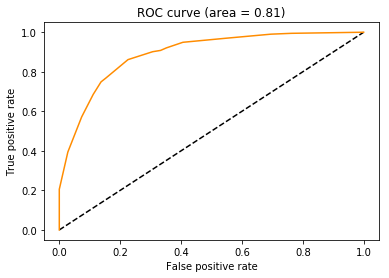

In [67]:
y_probs = dt.predict_proba(X_test)[:, 1]
y_predicted = dt.predict(X_test)

auc = roc_auc_score(y_test, y_predicted)

false_positive, true_positive, _  = roc_curve(y_test, y_probs)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive, true_positive, color='darkorange', label='Decision Tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = %0.2f)' % auc)
plt.show()

In [83]:
out = []
for mile in miles:
    now = pd.Timestamp.now().round('1d') 
    lat = data[data.mile==mile].lat.values[0]
    lon = data[data.mile==mile].lon.values[0]
    name = data[data.mile==mile].name.mode().values[0]
    
    result = {
        'lat': lat, 
        'lon': lon, 
        'name': name,
        'mile': mile
    }
    
    for days in range(4):
        prediction = dt.predict_proba([[
                    getRainSum(lat, lon, int(now.value/10**9) + (24*60*60*days), 5), 
                    last_pos(mile, now) + days, 
                    last_neg(mile, now) + days,
                    data[mile == data.mile].status.mean()
                ]])
         
        result[f'prediction_{days}'] = prediction[0][1]
    
    out.append(result)

    
f = open('out_combined.pkl', 'wb')
pickle.dump(out, f)
f.close() 

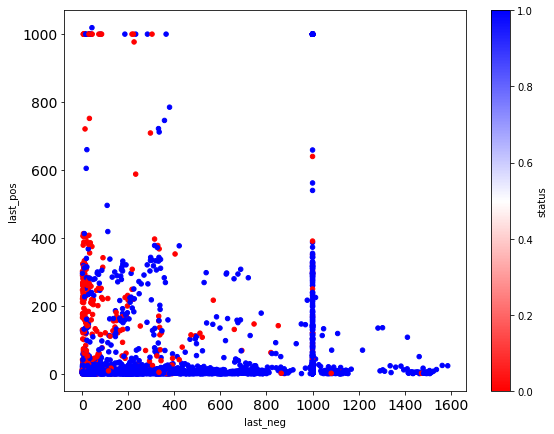

In [53]:
data.plot(kind='scatter',x="last_neg",y="last_pos",c="status", cmap=cm.get_cmap('bwr_r'), figsize=(9,7), fontsize=14)

In [66]:
dt.feature_importances_

array([ 0.05715764,  0.25951469,  0.14386357,  0.5394641 ])

In [58]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(dt, out_file='tree.dot', 
                feature_names = X_test.columns,
                class_names = ["dry","wet"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')